# Linear Programming with Python

## Overview

Linear programming (LP) forms the computational backbone of power system optimization. From economic dispatch to transmission planning, most operational decisions in power systems can be formulated as linear programs or extensions thereof. This lesson introduces LP concepts and demonstrates how to solve them using Python's PuLP library.

We'll start with the mathematical foundations, then build practical skills through increasingly complex examples. By the end, you'll be able to formulate and solve LP problems that arise in power system operations.

## Learning Objectives

By completing this lesson, you will be able to:

1. Formulate optimization problems in standard LP form
2. Use PuLP to define and solve linear programs
3. Extract and interpret solution values and dual variables
4. Implement basic economic dispatch as an LP
5. Extend LP to mixed-integer problems for discrete decisions
6. Debug infeasible problems and improve solver performance

In [1]:
# Import required libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pulp
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("PuLP version:", pulp.__version__)
print("Available solvers:", pulp.listSolvers(onlyAvailable=True))

PuLP version: 3.0.2
Available solvers: ['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD']


If PuLP is not installed, please install it with `pip install pulp`. Installing with `mamba` may not properly install the `PULP_CBC_CMD` solver.

## Linear Programming Basics

Linear programming solves optimization problems where both the objective function and constraints are linear. The standard form of an LP is:

**Minimize:** $c^T x$

**Subject to:**
- $Ax = b$ (equality constraints)
- $x \geq 0$ (non-negativity)

Where:
- $x$ is the vector of decision variables
- $c$ is the cost coefficient vector
- $A$ is the constraint matrix
- $b$ is the right-hand side vector

Let's start with a simple example to understand these components.

### Example 1: Simple Production Problem

A power plant can produce electricity using two generators:
- Generator A: Costs $25/MWh, can produce 0-100 MW
- Generator B: Costs $30/MWh, can produce 0-80 MW
- Total demand: 120 MW

What's the minimum cost dispatch?

In [2]:
# Mathematical formulation
print("Mathematical Formulation:")
print("="*40)
print("Decision variables:")
print("  x₁ = Power from Generator A (MW)")
print("  x₂ = Power from Generator B (MW)")
print("\nObjective function:")
print("  Minimize: 25x₁ + 30x₂")
print("\nConstraints:")
print("  x₁ + x₂ = 120  (demand)")
print("  0 ≤ x₁ ≤ 100   (Generator A limits)")
print("  0 ≤ x₂ ≤ 80    (Generator B limits)")

Mathematical Formulation:
Decision variables:
  x₁ = Power from Generator A (MW)
  x₂ = Power from Generator B (MW)

Objective function:
  Minimize: 25x₁ + 30x₂

Constraints:
  x₁ + x₂ = 120  (demand)
  0 ≤ x₁ ≤ 100   (Generator A limits)
  0 ≤ x₂ ≤ 80    (Generator B limits)


### Graphical Solution

For two-variable problems, we can visualize the solution graphically. This builds intuition for how LP works.

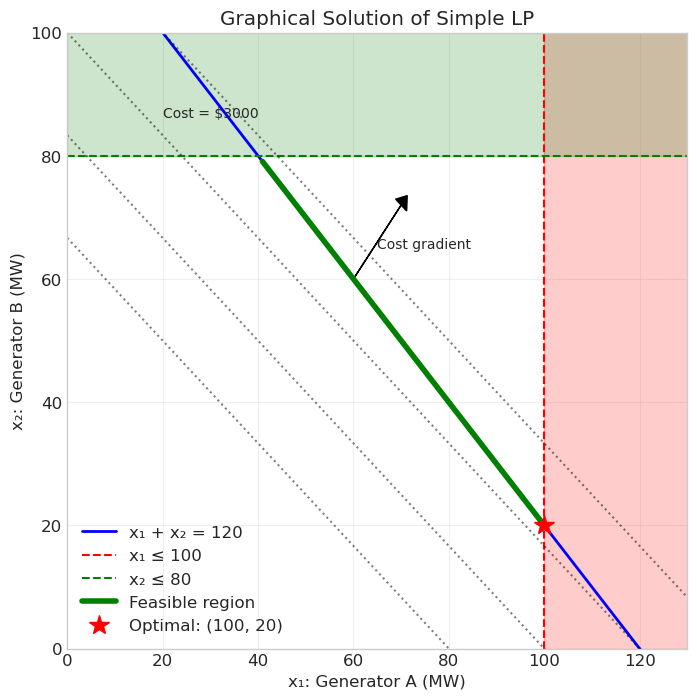


Optimal solution: x₁ = 100 MW, x₂ = 20 MW
Minimum cost: $3100


In [3]:
# Visualize the problem
fig, ax = plt.subplots(figsize=(8, 8))

# Define the demand constraint line: x1 + x2 = 120
x1_line = np.linspace(0, 150, 100)
x2_line = 120 - x1_line

# Plot demand constraint
ax.plot(x1_line, x2_line, 'b-', linewidth=2, label='x₁ + x₂ = 120')

# Plot generator limits
ax.axvline(x=100, color='r', linestyle='--', label='x₁ ≤ 100')
ax.axhline(y=80, color='g', linestyle='--', label='x₂ ≤ 80')

# Shade infeasible regions
ax.fill_between([100, 150], [0, 0], [150, 150], alpha=0.2, color='red')
ax.fill_between([0, 150], [80, 80], [150, 150], alpha=0.2, color='green')

# Find and mark feasible segment
feasible_x1 = x1_line[(x1_line >= 0) & (x1_line <= 100) & 
                      (x2_line >= 0) & (x2_line <= 80)]
feasible_x2 = 120 - feasible_x1
ax.plot(feasible_x1, feasible_x2, 'g-', linewidth=4, label='Feasible region')

# Plot cost contours
for cost in [2000, 2500, 3000, 3500]:
    x1_contour = np.linspace(0, 150, 100)
    x2_contour = (cost - 25*x1_contour) / 30
    ax.plot(x1_contour, x2_contour, 'k:', alpha=0.5)
    if cost == 3000:
        ax.text(20, (cost - 25*20)/30 + 3, f'Cost = ${cost}', fontsize=10)

# Mark optimal point
x1_opt = 100  # Use cheaper generator at max
x2_opt = 20   # Remainder from expensive generator
ax.plot(x1_opt, x2_opt, 'r*', markersize=15, label=f'Optimal: ({x1_opt}, {x2_opt})')

# Add arrow showing cost gradient
ax.arrow(60, 60, 10, 12, head_width=3, head_length=2, fc='black', ec='black')
ax.text(65, 65, 'Cost gradient', fontsize=10)

ax.set_xlim(0, 130)
ax.set_ylim(0, 100)
ax.set_xlabel('x₁: Generator A (MW)')
ax.set_ylabel('x₂: Generator B (MW)')
ax.set_title('Graphical Solution of Simple LP')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"\nOptimal solution: x₁ = {x1_opt} MW, x₂ = {x2_opt} MW")
print(f"Minimum cost: ${25*x1_opt + 30*x2_opt}")

## Introduction to PuLP

PuLP is a Python library for linear programming. It provides a simple interface to define and solve optimization problems. Let's solve the same problem using PuLP.

### Step 1: Create the Problem

In [4]:
from pulp import *

In [5]:
# Create a minimization problem
prob = LpProblem("Simple_Generator_Dispatch", LpMinimize)
print(f"Created problem: {prob.name}")
print(f"Sense: {prob.sense} (1 = minimize, -1 = maximize)")

Created problem: Simple_Generator_Dispatch
Sense: 1 (1 = minimize, -1 = maximize)


### Step 2: Define Decision Variables

In [6]:
# Create variables with bounds
x1 = LpVariable("GenA", lowBound=0, upBound=100)
x2 = LpVariable("GenB", lowBound=0, upBound=80)

print("Variables created:")
print(f"  {x1.name}: [{x1.lowBound}, {x1.upBound}]")
print(f"  {x2.name}: [{x2.lowBound}, {x2.upBound}]")

Variables created:
  GenA: [0, 100]
  GenB: [0, 80]


### Step 3: Set the Objective Function

In [7]:
# Define objective: minimize 25*x1 + 30*x2
prob += 25*x1 + 30*x2, "Total_Cost"

print("Objective function:")
print(f"  Minimize: {prob.objective}")

Objective function:
  Minimize: 25*GenA + 30*GenB


### Step 4: Add Constraints

In [8]:
# Add demand constraint
prob += x1 + x2 == 120, "Demand_Constraint"

print("Constraints added:")
for name, constraint in prob.constraints.items():
    print(f"  {name}: {constraint}")

Constraints added:
  Demand_Constraint: GenA + GenB = 120


### Step 5: Solve the Problem

In [9]:
# Solve using default solver
status = prob.solve(PULP_CBC_CMD(msg=0))
# `msg=0` suppresses solver progress information

# Display results
print(f"Solver status: {LpStatus[status]}")
print(f"\nOptimal solution:")
print(f"  {x1.name} = {value(x1)} MW")
print(f"  {x2.name} = {value(x2)} MW")
print(f"\nMinimum cost: ${value(prob.objective)}")

Solver status: Optimal

Optimal solution:
  GenA = 100.0 MW
  GenB = 20.0 MW

Minimum cost: $3100.0


### Step 6: Extract Dual Variables (Shadow Prices)

Dual variables tell us the marginal value of relaxing constraints. In power systems, this gives us the Locational Marginal Price (LMP).

In [10]:
# Get shadow price (dual variable) of demand constraint
shadow_price = prob.constraints["Demand_Constraint"].pi

print(f"Shadow price of demand constraint: ${shadow_price}/MW")
print("\nInterpretation:")
print(f"  - Each additional MW of demand increases cost by ${shadow_price}")
print(f"  - This is the marginal cost of generation")
print(f"  - In electricity markets, this would be the LMP")

Shadow price of demand constraint: $30.0/MW

Interpretation:
  - Each additional MW of demand increases cost by $30.0
  - This is the marginal cost of generation
  - In electricity markets, this would be the LMP


## Economic Dispatch as Linear Programming

Now let's implement a more realistic economic dispatch problem with multiple generators.

In [11]:
# Create generator data
def create_generator_data(n_units=3):
    """Create simple generator DataFrame for examples."""
    data = {
        'p_min': np.linspace(20, 100, n_units),
        'p_max': np.linspace(100, 400, n_units),
        'cost': np.linspace(20, 35, n_units)
    }
    return pd.DataFrame(data, index=[f'G{i+1}' for i in range(n_units)])


generators = create_generator_data(n_units=3)
demand = 350  # MW

print("Generator Data:")
print(generators)
print(f"\nSystem demand: {demand} MW")

Generator Data:
    p_min  p_max  cost
G1   20.0  100.0  20.0
G2   60.0  250.0  27.5
G3  100.0  400.0  35.0

System demand: 350 MW


### Formulate and Solve ED

In [12]:
# Create problem
ed_prob = LpProblem("Economic_Dispatch", LpMinimize)

# Decision variables
p_gen = {}
for g in generators.index:
    p_gen[g] = LpVariable(f"P_{g}", 
                         lowBound=generators.loc[g, 'p_min'],
                         upBound=generators.loc[g, 'p_max'])

print("Decision variables created:")
for g, var in p_gen.items():
    print(f"  {var.name}: [{var.lowBound}, {var.upBound}] MW")

Decision variables created:
  P_G1: [20.0, 100.0] MW
  P_G2: [60.0, 250.0] MW
  P_G3: [100.0, 400.0] MW


In [13]:
# Objective function
ed_prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index)

print("Objective function:")
print(f"  Minimize: {ed_prob.objective}")

Objective function:
  Minimize: 20.0*P_G1 + 27.5*P_G2 + 35.0*P_G3


In [14]:
# Power balance constraint
ed_prob += lpSum(p_gen[g] for g in generators.index) == demand, "Power_Balance"

print("Constraint added:")
print(f"  Power_Balance: {ed_prob.constraints['Power_Balance']}")

Constraint added:
  Power_Balance: P_G1 + P_G2 + P_G3 = 350.0


In [15]:
# Solve
ed_prob.solve(PULP_CBC_CMD(msg=0))

# Display results
print(f"Status: {LpStatus[ed_prob.status]}")
print(f"\nOptimal dispatch:")
total_gen = 0
for g in generators.index:
    gen_value = value(p_gen[g])
    total_gen += gen_value
    print(f"  {g}: {gen_value:.1f} MW (cost: ${generators.loc[g, 'cost']}/MWh)")

print(f"\nTotal generation: {total_gen:.1f} MW")
print(f"Total cost: ${value(ed_prob.objective):.2f}/hour")

# LMP
lmp = ed_prob.constraints["Power_Balance"].pi
print(f"\nSystem LMP: ${lmp:.2f}/MWh")

Status: Optimal

Optimal dispatch:
  G1: 100.0 MW (cost: $20.0/MWh)
  G2: 150.0 MW (cost: $27.5/MWh)
  G3: 100.0 MW (cost: $35.0/MWh)

Total generation: 350.0 MW
Total cost: $9625.00/hour

System LMP: $27.50/MWh


### Verify Economic Dispatch Principle

In optimal dispatch, all generators at interior points (not at limits) should have the same marginal cost, equal to the LMP.

In [16]:
print("Verification of Economic Dispatch:")
print("="*40)

for g in generators.index:
    gen_value = value(p_gen[g])
    marginal_cost = generators.loc[g, 'cost']
    
    # Check if at limits
    at_min = abs(gen_value - generators.loc[g, 'p_min']) < 0.1
    at_max = abs(gen_value - generators.loc[g, 'p_max']) < 0.1
    
    status = "at min" if at_min else "at max" if at_max else "interior"
    
    print(f"{g}: MC = ${marginal_cost}/MWh, Output = {gen_value:.1f} MW ({status})")

print(f"\nSystem LMP: ${lmp:.2f}/MWh")
print("\nNote: LMP equals the marginal cost of the marginal generator")

Verification of Economic Dispatch:
G1: MC = $20.0/MWh, Output = 100.0 MW (at max)
G2: MC = $27.5/MWh, Output = 150.0 MW (interior)
G3: MC = $35.0/MWh, Output = 100.0 MW (at min)

System LMP: $27.50/MWh

Note: LMP equals the marginal cost of the marginal generator


## Sensitivity Analysis

Let's examine how the solution changes as demand varies.

In [17]:
# Solve ED for different demand levels
demand_range = np.linspace(100, 500, 20)
results = []

for d in demand_range:
    # Create and solve problem
    prob = LpProblem(f"ED_{d}", LpMinimize)
    
    # Variables
    p = {g: LpVariable(f"P_{g}", generators.loc[g, 'p_min'], 
                      generators.loc[g, 'p_max']) for g in generators.index}
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p[g] for g in generators.index)
    
    # Constraint
    prob += lpSum(p[g] for g in generators.index) == d, "Balance"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    if prob.status == 1:
        results.append({
            'demand': d,
            'cost': value(prob.objective),
            'lmp': prob.constraints["Balance"].pi,
            'G1': value(p['G1']),
            'G2': value(p['G2']),
            'G3': value(p['G3'])
        })

results_df = pd.DataFrame(results)

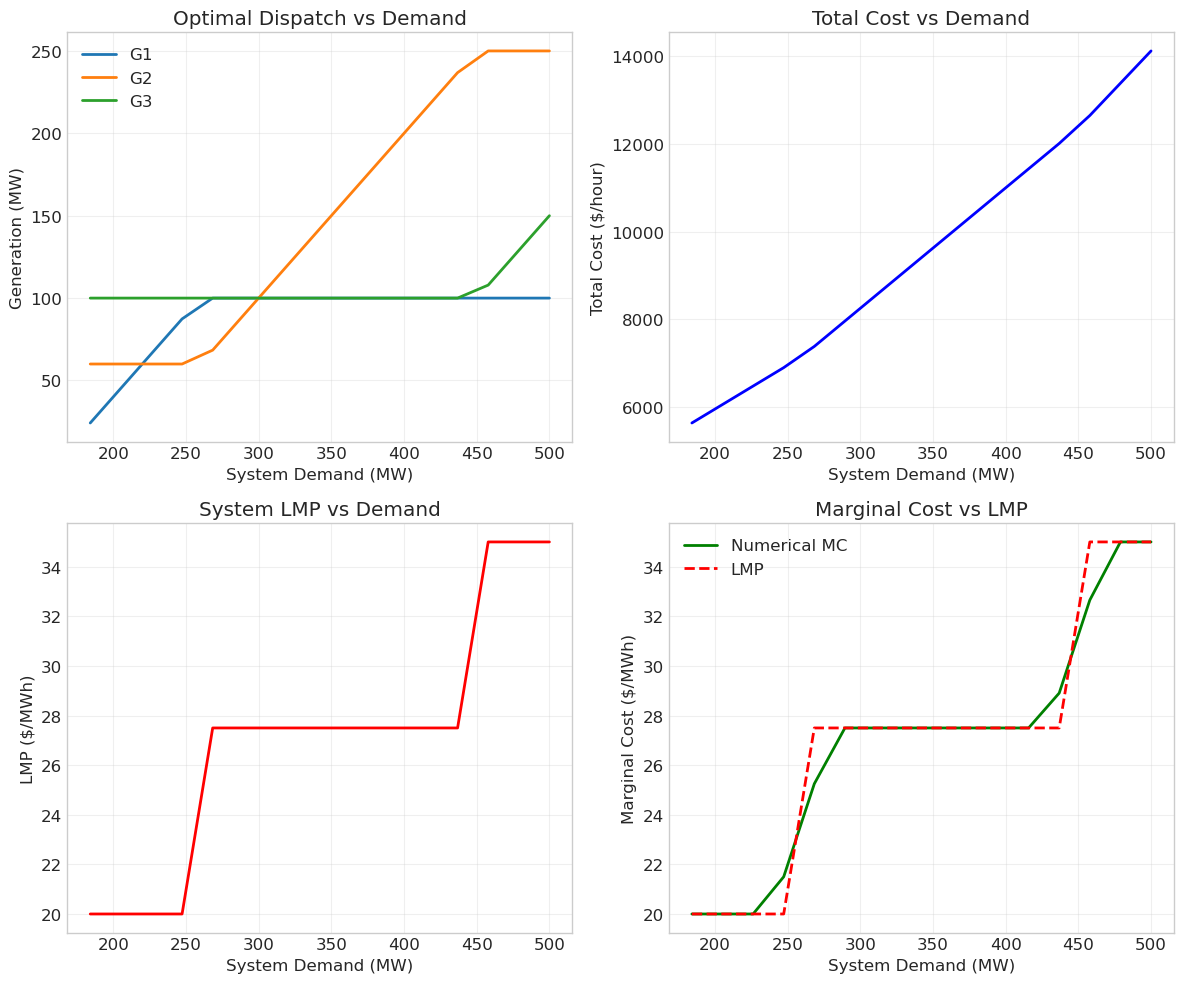

In [18]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Generation dispatch
ax = axes[0, 0]
ax.plot(results_df['demand'], results_df['G1'], label='G1', linewidth=2)
ax.plot(results_df['demand'], results_df['G2'], label='G2', linewidth=2)
ax.plot(results_df['demand'], results_df['G3'], label='G3', linewidth=2)
ax.set_xlabel('System Demand (MW)')
ax.set_ylabel('Generation (MW)')
ax.set_title('Optimal Dispatch vs Demand')
ax.legend()
ax.grid(True, alpha=0.3)

# Total cost
ax = axes[0, 1]
ax.plot(results_df['demand'], results_df['cost'], 'b-', linewidth=2)
ax.set_xlabel('System Demand (MW)')
ax.set_ylabel('Total Cost ($/hour)')
ax.set_title('Total Cost vs Demand')
ax.grid(True, alpha=0.3)

# LMP
ax = axes[1, 0]
ax.plot(results_df['demand'], results_df['lmp'], 'r-', linewidth=2)
ax.set_xlabel('System Demand (MW)')
ax.set_ylabel('LMP ($/MWh)')
ax.set_title('System LMP vs Demand')
ax.grid(True, alpha=0.3)

# Marginal cost curve
ax = axes[1, 1]
# Calculate marginal cost (derivative of total cost)
marginal_cost = np.gradient(results_df['cost'], results_df['demand'])
ax.plot(results_df['demand'], marginal_cost, 'g-', linewidth=2, label='Numerical MC')
ax.plot(results_df['demand'], results_df['lmp'], 'r--', linewidth=2, label='LMP')
ax.set_xlabel('System Demand (MW)')
ax.set_ylabel('Marginal Cost ($/MWh)')
ax.set_title('Marginal Cost vs LMP')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The sensitivity analysis reveals the piecewise-linear nature of power system economics. As demand increases, generators are dispatched in merit order (cheapest first), creating distinct operating regions visible in the generation dispatch plot. The total cost curve shows increasing slopes at breakpoints where more expensive generators come online. Most notably, the LMP exhibits step changes at these transition points, i.e., jumping to the next generator's marginal cost when that unit becomes marginal. This discrete behavior shows why small changes in demand can sometimes cause significant price shifts.

## Introduction to Mixed-Integer Linear Programming

Many power system decisions are discrete (on/off, build/don't build). These require binary or integer variables, leading to Mixed-Integer Linear Programs (MILP).

### Example: Simple Unit Commitment

Let's add on/off decisions to our generators, including startup costs.

In [19]:
# Generator data with startup costs
gen_data_uc = pd.DataFrame({
    'p_min': [50, 40, 60],
    'p_max': [150, 120, 180],
    'cost': [25, 30, 22],
    'startup_cost': [100, 150, 200]
}, index=['G1', 'G2', 'G3'])

hours = 4
demand_profile = [200, 250, 300, 220]  # MW per hour

print("Generator Data:")
print(gen_data_uc)
print(f"\nDemand profile: {demand_profile} MW")

Generator Data:
    p_min  p_max  cost  startup_cost
G1     50    150    25           100
G2     40    120    30           150
G3     60    180    22           200

Demand profile: [200, 250, 300, 220] MW


In [20]:
# Create MILP problem
uc_prob = LpProblem("Simple_Unit_Commitment", LpMinimize)

# Decision variables
# Binary: unit on/off
u = {}
# Continuous: power output
p = {}
# Binary: startup indicator
v = {}

for g in gen_data_uc.index:
    for t in range(hours):
        u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
        p[g,t] = LpVariable(f"p_{g}_{t}", lowBound=0)
        v[g,t] = LpVariable(f"v_{g}_{t}", cat='Binary')

print(f"Variables created:")
print(f"  Binary variables (on/off): {len(u)}")
print(f"  Continuous variables (power): {len(p)}")
print(f"  Binary variables (startup): {len(v)}")

Variables created:
  Binary variables (on/off): 12
  Continuous variables (power): 12
  Binary variables (startup): 12


In [21]:
# Objective: minimize generation cost + startup cost
generation_cost = lpSum(gen_data_uc.loc[g, 'cost'] * p[g,t] 
                       for g in gen_data_uc.index for t in range(hours))
startup_cost = lpSum(gen_data_uc.loc[g, 'startup_cost'] * v[g,t]
                    for g in gen_data_uc.index for t in range(hours))

uc_prob += generation_cost + startup_cost

print("Objective function: Minimize (generation_cost + startup_cost)")

Objective function: Minimize (generation_cost + startup_cost)


In [22]:
# Constraints
# 1. Power balance
for t in range(hours):
    uc_prob += lpSum(p[g,t] for g in gen_data_uc.index) == demand_profile[t], f"Demand_{t}"

# 2. Generation limits (only produce if unit is on)
for g in gen_data_uc.index:
    for t in range(hours):
        uc_prob += p[g,t] >= gen_data_uc.loc[g, 'p_min'] * u[g,t]
        uc_prob += p[g,t] <= gen_data_uc.loc[g, 'p_max'] * u[g,t]

# 3. Startup logic
for g in gen_data_uc.index:
    for t in range(hours):
        if t == 0:
            # Assume all units start off
            uc_prob += v[g,t] >= u[g,t]
        else:
            # Startup if turning on
            uc_prob += v[g,t] >= u[g,t] - u[g,t-1]

print(f"Constraints added: {len(uc_prob.constraints)}")

Constraints added: 40


In [23]:
# Solve MILP
uc_prob.solve(PULP_CBC_CMD(msg=0))

print(f"Status: {LpStatus[uc_prob.status]}")
print(f"Total cost: ${value(uc_prob.objective):.2f}")

Status: Optimal
Total cost: $22510.00


In [24]:
# Extract and display results
schedule = pd.DataFrame(index=gen_data_uc.index, columns=range(hours))
dispatch = pd.DataFrame(index=gen_data_uc.index, columns=range(hours))

for g in gen_data_uc.index:
    for t in range(hours):
        schedule.loc[g, t] = int(value(u[g,t]))
        dispatch.loc[g, t] = value(p[g,t]) if value(u[g,t]) > 0.5 else 0

print("\nUnit Commitment Schedule (1=ON, 0=OFF):")
print(schedule)
print("\nPower Dispatch (MW):")
print(dispatch.round(1))


Unit Commitment Schedule (1=ON, 0=OFF):
    0  1  2  3
G1  1  1  1  1
G2  0  0  0  0
G3  1  1  1  1

Power Dispatch (MW):
        0      1      2      3
G1   50.0   70.0  120.0   50.0
G2      0      0      0      0
G3  150.0  180.0  180.0  170.0


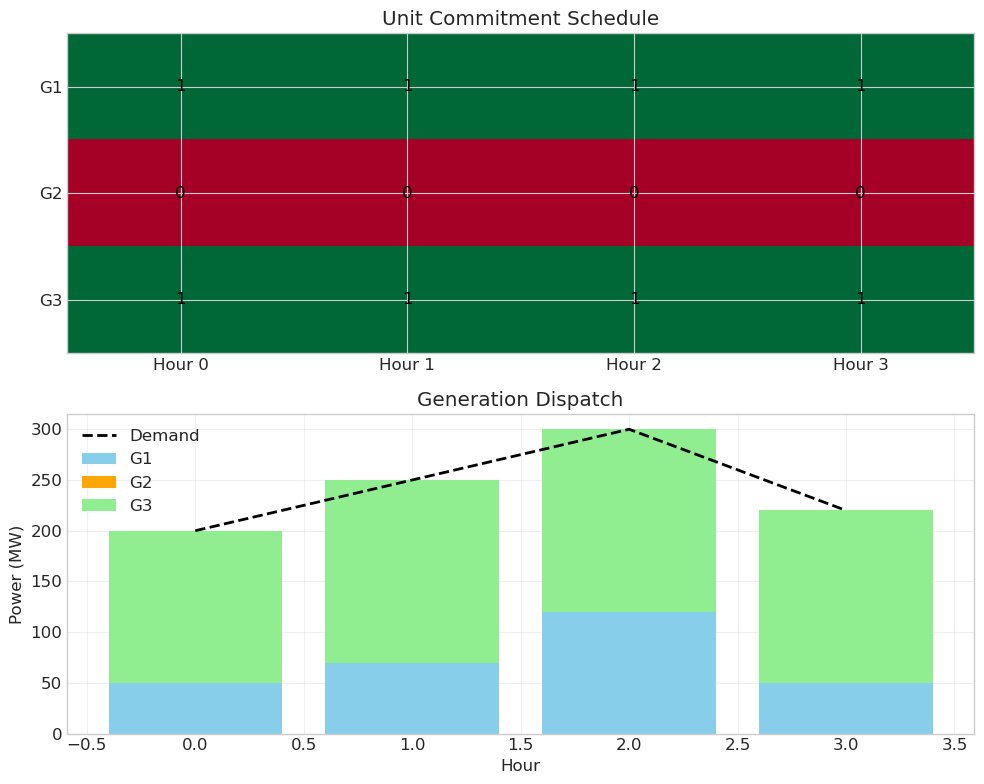

In [29]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Unit status
status_matrix = schedule.values.astype(int)
im1 = ax1.imshow(status_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(range(hours))
ax1.set_xticklabels([f'Hour {t}' for t in range(hours)])
ax1.set_yticks(range(len(gen_data_uc)))
ax1.set_yticklabels(gen_data_uc.index)
ax1.set_title('Unit Commitment Schedule')

# Add text annotations
for i in range(len(gen_data_uc)):
    for j in range(hours):
        text = ax1.text(j, i, status_matrix[i, j],
                       ha="center", va="center", color="black")

# Generation dispatch
bottom = np.zeros(hours)
colors = ['skyblue', 'orange', 'lightgreen']

for i, g in enumerate(gen_data_uc.index):
    values = dispatch.loc[g].values.astype(float)
    ax2.bar(range(hours), values, bottom=bottom, label=g, color=colors[i])
    bottom += values

ax2.plot(range(hours), demand_profile, 'k--', linewidth=2, label='Demand')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Power (MW)')
ax2.set_title('Generation Dispatch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PuLP Best Practices

Let's cover some important tips for using PuLP effectively.

### Debugging Infeasible Problems

In [30]:
# Create an infeasible problem
infeas_prob = LpProblem("Infeasible_Example", LpMinimize)

x = LpVariable("x", lowBound=0, upBound=10)
y = LpVariable("y", lowBound=0, upBound=10)

infeas_prob += x + y  # Objective
infeas_prob += x + y >= 15  # Constraint 1
infeas_prob += x + y <= 5   # Constraint 2 (conflicts with 1)

# Solve
infeas_prob.solve()

print(f"Status: {LpStatus[infeas_prob.status]}")

if infeas_prob.status == -1:  # Infeasible
    print("\nProblem is infeasible. Checking constraints...")
    print("\nConstraints:")
    for name, constraint in infeas_prob.constraints.items():
        print(f"  {constraint}")
    
    print("\nVariable bounds:")
    for var in infeas_prob.variables():
        print(f"  {var.name}: [{var.lowBound}, {var.upBound}]")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hcui9/miniforge3/envs/a/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/81de84f166014dbb9e1d4280f1529dd1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/81de84f166014dbb9e1d4280f1529dd1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 14 RHS
At line 17 BOUNDS
At line 20 ENDATA
Problem MODEL has 2 rows, 2 columns and 4 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj 0 Primal inf 15 (1)
Primal infeasible - objective value 15
PrimalInfeasible objective 15 - 1 iterations time 0.002

Result - Linear relaxation infeasible

Enumerated nodes:           0
Total iterations:           0
Time (CPU seconds):         0.00
Time (Wall

The problem is infeasible because we are asking for contradictory conditions: the sum of x and y must be at least 15 but also at most 5. Since both variables are bounded between 0 and 10, their maximum sum is 20, which satisfies the lower bound but violates the impossibility of being both ≥15 and ≤5 simultaneously. When PuLP encounters such conflicts, it returns an "Infeasible" status.

In [31]:
# Simple diagnostic: Check if removing each constraint helps
print("\nTesting each constraint individually:")
print("="*40)

for name in infeas_prob.constraints:
    # Create problem with just one constraint
    test_prob = LpProblem("Test", LpMinimize)
    x_test = LpVariable("x", lowBound=0, upBound=10)
    y_test = LpVariable("y", lowBound=0, upBound=10)
    
    test_prob += x_test + y_test
    
    # Add only this constraint
    if name == "Lower_Bound":
        test_prob += x_test + y_test >= 15
    else:  # Upper_Bound
        test_prob += x_test + y_test <= 5
    
    test_prob.solve(PULP_CBC_CMD(msg=0))
    print(f"  With only '{name}': {LpStatus[test_prob.status]}")



Testing each constraint individually:
  With only '_C1': Optimal
  With only '_C2': Optimal


By testing each constraint individually, we can identify which constraints are problematic. Here we see that the lower bound constraint alone is feasible (we can achieve `x+y=15` with `x=10`, `y=5`), and the upper bound alone is also feasible (we can achieve x+y=5 with x=0, y=5). The infeasibility only arises when both constraints are enforced together, confirming they are mutually exclusive.

In practical large-scale optimization problems, it can be much harder to isolate the constraints because removing some constraints can make the optimization problem unbounded. The next approach is to introduce slack variables to constraints that can potentially cause infeasibility, and then penalize in the objective function.

#### Relax by adding slack variables

In [32]:
print("\nRelaxing with slack variables:")
print("="*40)

relax_prob = LpProblem("Relaxed_Problem", LpMinimize)

x = LpVariable("x", lowBound=0, upBound=10)
y = LpVariable("y", lowBound=0, upBound=10)
slack_lower = LpVariable("slack_lower", lowBound=0)
slack_upper = LpVariable("slack_upper", lowBound=0)

# Minimize original objective + penalty for violations
penalty = 100
relax_prob += x + y + penalty * (slack_lower + slack_upper)

# Relaxed constraints
relax_prob += x + y + slack_lower >= 15, "Soft_Lower"
relax_prob += x + y - slack_upper <= 5, "Soft_Upper"

relax_prob.solve(PULP_CBC_CMD(msg=0))

print(f"Status: {LpStatus[relax_prob.status]}")
print(f"\nSolution:")
print(f"  x = {value(x):.1f}, y = {value(y):.1f}")
print(f"  Lower bound slack = {value(slack_lower):.1f}")
print(f"  Upper bound slack = {value(slack_upper):.1f}")


Relaxing with slack variables:
Status: Optimal

Solution:
  x = 5.0, y = 0.0
  Lower bound slack = 10.0
  Upper bound slack = 0.0


The above shows a way to handle infeasibility is to make constraints "soft" by adding slack variables that allow violations at a cost. The slack variables measure how much each constraint is violated, and we add a penalty term to the objective function to discourage violations. In this solution, the optimizer finds the best compromise: satisfying the upper bound (`x+y=5`) while accepting a 10-unit violation of the lower bound. The high penalty ensures we only violate constraints when absolutely necessary.

#### Alternative: Find feasible middle ground

Another approach is to adjust the constraint bounds to create a feasible region. Instead of the impossible range `[15, 5]`, we manually guess a valid range `[8, 12]` to poke the optimization problem. The optimizer then minimizes within this feasible region, giving us `x=y=4` for a sum of `8`. This approach is useful when you have flexibility in the constraint values and can negotiate more realistic requirements. In other times, the results may not be immediately useful, but it can help identify 

In [34]:
print("\nFinding feasible middle ground:")
print("="*40)

# The constraints want x+y >= 15 and x+y <= 5
# Maximum possible is x+y = 20, minimum is 0
# Let's relax to a feasible range

middle_prob = LpProblem("Middle_Ground", LpMinimize)

x = LpVariable("x", lowBound=0, upBound=10)
y = LpVariable("y", lowBound=0, upBound=10)

middle_prob += x + y

# Use achievable bounds
middle_prob += x + y >= 8   # Relaxed from 15
middle_prob += x + y <= 12  # Relaxed from 5

middle_prob.solve(PULP_CBC_CMD(msg=0))

print(f"Original constraints: x+y >= 15 AND x+y <= 5")
print(f"Relaxed constraints: x+y >= 8 AND x+y <= 12")
print(f"\nStatus: {LpStatus[middle_prob.status]}")
print(f"Solution: x = {value(x):.1f}, y = {value(y):.1f}")
print(f"Sum: {value(x) + value(y):.1f}")


Finding feasible middle ground:
Original constraints: x+y >= 15 AND x+y <= 5
Relaxed constraints: x+y >= 8 AND x+y <= 12

Status: Optimal
Solution: x = 8.0, y = 0.0
Sum: 8.0


### Choosing Solvers

In [35]:
# Compare different solvers
import time

# Create a test problem
test_prob = LpProblem("Test", LpMinimize)
test_vars = [LpVariable(f"x{i}", 0, 100) for i in range(100)]
test_prob += lpSum(test_vars)
test_prob += lpSum(test_vars) >= 1000

# Test available solvers
solvers_to_test = []
if PULP_CBC_CMD().available():
    solvers_to_test.append(("CBC", PULP_CBC_CMD(msg=0)))
if GLPK_CMD().available():
    solvers_to_test.append(("GLPK", GLPK_CMD(msg=0)))

print("Solver Performance Comparison:")
print("="*40)

for name, solver in solvers_to_test:
    # Copy problem
    prob_copy = test_prob.copy()
    
    # Solve and time
    start = time.time()
    prob_copy.solve(solver)
    solve_time = time.time() - start
    
    print(f"{name}:")
    print(f"  Status: {LpStatus[prob_copy.status]}")
    print(f"  Objective: {value(prob_copy.objective):.2f}")
    print(f"  Time: {solve_time:.4f} seconds")
    print()

Solver Performance Comparison:
CBC:
  Status: Optimal
  Objective: 1000.00
  Time: 0.0027 seconds

GLPK:
  Status: Optimal
  Objective: 1000.00
  Time: 0.0058 seconds



### Writing LP to File

In [36]:
# Save problem to LP format file
filename = "example_problem.lp"
ed_prob.writeLP(filename)

print(f"Problem written to {filename}")
print("\nFirst 20 lines of LP file:")
with open(filename, 'r') as f:
    for i, line in enumerate(f):
        if i < 20:
            print(line.rstrip())
        else:
            break

# Clean up
os.remove(filename)

Problem written to example_problem.lp

First 20 lines of LP file:
\* Economic_Dispatch *\
Minimize
OBJ: 20 P_G1 + 27.5 P_G2 + 35 P_G3
Subject To
Power_Balance: P_G1 + P_G2 + P_G3 = 350
Bounds
 20 <= P_G1 <= 100
 60 <= P_G2 <= 250
 100 <= P_G3 <= 400
End


### Performance Tips

1. Use dictionaries for large variable sets:
   Good: `p = {g: LpVariable(f'p_{g}') for g in generators}`
   Avoid:  `p1, p2, p3, ... = LpVariable('p1'), LpVariable('p2'), ...`

This improves code readability.

3. Use lpSum for efficient summation:
   Good: `lpSum(cost[i] * x[i] for i in items)`
   Avoid:  `sum(cost[i] * x[i] for i in items)`

4. Set solver parameters for large problems:
   `solver = PULP_CBC_CMD(timeLimit=60, msg=0, gapRel=0.01)`

5. Use sparse formulations:
   Only create variables and constraints that are needed

6. Warm start when solving similar problems:
   Use previous solution as initial guess - this is called warm start.

## Summary

This lesson introduced linear programming fundamentals and PuLP implementation:

1. **LP Basics**: Standard form, objective functions, constraints, and graphical interpretation

2. **PuLP Workflow**: Creating problems, defining variables, setting objectives, adding constraints, and solving

3. **Economic Dispatch**: Implementing basic ED as an LP, verifying optimality conditions, and extracting LMPs

4. **Sensitivity Analysis**: Understanding how solutions change with problem parameters

5. **Mixed-Integer LP**: Adding binary variables for discrete decisions like unit commitment

6. **Best Practices**: Debugging infeasible problems, choosing solvers, and optimizing performance

## Key Takeaways

- **LP is foundational**: Most power system optimization problems start as LPs or build upon LP concepts

- **PuLP provides simplicity**: Clean Python interface for formulating and solving optimization problems

- **Dual variables matter**: Shadow prices give economic interpretation (LMPs in power systems)

- **Integer variables add complexity**: MILPs take longer to solve but model discrete decisions

- **Start simple**: Build complexity gradually, verify each step